In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import aparent.visualization as vis

from aparent.predictor import *


Using TensorFlow backend.


<h2>Load APARENT model</h2>
<br/>
-- Load APARENT, which has been trained to predict the isoform abundance and cut profile of a proximal PAS given a fixed background distal PAS (trained on random 3' UTR APA MPRA data).<br/>

In [2]:
#Load base APARENT model

save_dir = os.path.join(os.getcwd(), '../../saved_models')
model_name = 'aparent_large_lessdropout_all_libs_no_sampleweights.h5'
model_path = os.path.join(save_dir, model_name)

aparent_model = load_model(model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
#Load APADB Data and filter on targeted genes

#genes = ['RUNX1', 'CEBPA', 'GATA2', 'ANKRD26', 'DDX41', 'ETV6', 'PTEN', 'BRCA1', 'BRCA2', 'TP53', 'APC', 'ATM', 'PALB2', 'MSH2', 'MLH1', 'MSH6', 'PMS2', 'MUTYH']

polyadb_df = pd.read_csv('../../data/native_data/polyadb/processed_data/polyadb_processed.csv', sep=',')

#polyadb_df = polyadb_df.loc[polyadb_df['gene'].isin(genes)].reset_index(drop=True).copy()
polyadb_df = polyadb_df.loc[~polyadb_df['gene'].isna()].reset_index(drop=True).copy()
polyadb_df = polyadb_df.loc[polyadb_df['gene'] != 'na'].reset_index(drop=True).copy()

print('len(polyadb_df) = ' + str(len(polyadb_df)))


len(polyadb_df) = 190117


In [4]:
polyadb_df_minus = polyadb_df.query("strand == '-'").copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df.query("strand == '+'").copy().reset_index(drop=True)

polyadb_df_minus = polyadb_df_minus.sort_values(by='pas_pos', ascending=False).copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df_plus.sort_values(by='pas_pos', ascending=True).copy().reset_index(drop=True)

new_gene_id_list_plus = []
sitenum_list_plus = []
gene_id_dict = {}
for _, row in polyadb_df_plus.iterrows() :

    gene = str(row['gene'])

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_plus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_plus.append(gene_id_dict[gene])

polyadb_df_plus['gene_id'] = new_gene_id_list_plus
polyadb_df_plus['sitenum'] = sitenum_list_plus

new_gene_id_list_minus = []
sitenum_list_minus = []
gene_id_dict = {}
for _, row in polyadb_df_minus.iterrows() :

    gene = str(row['gene'])

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_minus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_minus.append(gene_id_dict[gene])

polyadb_df_minus['gene_id'] = new_gene_id_list_minus
polyadb_df_minus['sitenum'] = sitenum_list_minus

polyadb_df = pd.concat([polyadb_df_plus, polyadb_df_minus])

polyadb_df = polyadb_df.sort_values(by=['gene', 'sitenum'], ascending=True).reset_index(drop=True).copy()

In [5]:
polyadb_df.head()

,gene,gene_id,sitenum,num_sites,pas,seq,seq_ext,wide_seq,wide_seq_ext,rpm,total_rpm,ratio,pas_pos,cut_mode,chrom,strand,site_type
0,A1BG,A1BG.1,1,11,0,TTCTGCTAGGCTGGGCTAGTATCTTCCATGGCAAGATACTCAAACT...,TAGGGAATATAACTTTTAAAATGCGAAAGTATATTATACATATTGC...,AGTTTGGCTAGCATTTCAAAATGGATAGGGAATATAACTTTTAAAA...,GCTTTCAAAATTCCTGATTAGCTTACAATTAATTGCAAATAACTTC...,1.564234,24.390222,0.064134,58859852,58859830,chr19,-,Intron
1,A1BG,A1BG.2,2,11,-1,AGGTGCCGCTACCGCTCCTGGGTGCCCCACACCTTCGAATCGGAGC...,CGGCGAACCTCGAGCTGATCTTCGTGGGGCCCCAGCACGCCGGCAA...,AAGACGGTCCGCACCCCCGGGGCCGCGGCGAACCTCGAGCTGATCT...,TCCCCGACGTCACCTTCGAGCTGCTGCGCGAGGGCGAGACGAAGGC...,1.740036,24.390222,0.071342,58858744,58858719,chr19,-,Internal_exon
2,A1BG,A1BG.3,3,11,0,CCGGGGTCTCTGGGGGGCTGGAGAAGCCTCCCTCATTCCTCCCAGG...,AGTGCCGGGGATTCTGGACTGGCTCCCTCCCCTCCTGTTGCAGCAC...,CCAGGGTGCTGTTGGTGTCCTCAGAAGTGCCGGGGATTCTGGACTG...,CACCATTTCTCTTTTCTCCCGTTGTCTAGAAAGCTGATGCAGCCGC...,11.529986,24.390222,0.472730,58858249,58858220,chr19,-,3_most_exon
3,A1BG,A1BG.4,4,11,4,GAAGATGCGTATCAGTATTATCAACCAATAGTTGATGAATTGTGTT...,ACCACTGCCGAGTTTCTGCCTGGAGCAGGGCCTCAAGGCCCTGGCA...,CCATCTGACATCTGATGCCTTCCCAACCACTGCCGAGTTTCTGCCT...,GATTCCTCTGTGTTCTTTCCCATTATCCCTCAGCTCTGAGTCCTCT...,1.386686,24.390222,0.056854,58857215,58857210,chr19,-,3_most_exon
4,A1BG,A1BG.5,5,11,4,AACGAATTTGCTAGTGATCTGGTTTACTGCCTTAGTAATATCTAGT...,GAAGATGCGTATCAGTATTATCAACCAATAGTTGATGAATTGTGTT...,CAGGGCCTCAAGGCCCTGGCACACAGAAGATGCGTATCAGTATTAT...,CCATCTGACATCTGATGCCTTCCCAACCACTGCCGAGTTTCTGCCT...,1.174863,24.390222,0.048169,58857165,58857142,chr19,-,3_most_exon


In [6]:

polyadb_df['start'] = polyadb_df['pas_pos'] - 100
polyadb_df['end'] = polyadb_df['pas_pos'] + 100

polyadb_bed = polyadb_df[['chrom', 'start', 'end', 'gene', 'gene_id', 'strand']].copy().reset_index(drop=True)

polyadb_bed.head()

polyadb_bed.to_csv("polyadb_coordinates.bed", sep='\t', header=False, index=False)


In [7]:

!bedtools intersect -a polyadb_coordinates.bed -b gwas_catalog_hg19.bed -wa -wb > polyadb_gwas_intersect.bed


In [8]:

gwas_bed_hg19 = pd.read_csv("polyadb_gwas_intersect.bed", sep='\t', error_bad_lines=False, names=['chrom', 'start', 'end', 'gene', 'gene_id', 'strand', 'chr_2', 'snp_pos', 'end_2', 'gene_2', 'snp_id', 'trait', 'p_value', 'p_value_mlog', 'molecular_cause'])
gwas_bed_hg19 = gwas_bed_hg19.query("gene == gene_2").copy().reset_index(drop=True)
gwas_bed_hg19 = gwas_bed_hg19.query("molecular_cause == '3_prime_UTR_variant' or molecular_cause == 'intron_variant'").copy().reset_index(drop=True)

gwas_bed_hg19 = gwas_bed_hg19[['chrom', 'start', 'end', 'gene', 'gene_id', 'strand', 'snp_pos', 'snp_id', 'trait', 'p_value', 'p_value_mlog', 'molecular_cause']]

gwas_bed_hg19['snp'] = gwas_bed_hg19['snp_id'].apply(lambda s: s.split("-")[1][0])
gwas_bed_hg19 = gwas_bed_hg19.query("snp != '?'").copy().reset_index(drop=True)

print(len(gwas_bed_hg19))
print(gwas_bed_hg19.head())


839
   chrom      start        end     gene    gene_id strand    snp_pos  \
0  chr19    1050315    1050515    ABCA7    ABCA7.3      +    1050420   
1  chr21   43622264   43622464    ABCG1    ABCG1.1      +   43622267   
2  chr15   81009487   81009687  ABHD17C  ABHD17C.1      +   81009646   
3   chr1  179071645  179071845     ABL2    ABL2.11      -  179071756   
4  chr18   47309529   47309729    ACAA2    ACAA2.7      -   47309540   

          snp_id                                              trait p_value  \
0  rs115550680-G                   Alzheimer's disease (late onset)   2e-09   
1    rs4148087-A                Eating disorder in bipolar disorder   4e-07   
2    rs2759315-C                                    Body mass index   5e-11   
3    rs1325195-A                            IgE grass sensitization   5e-06   
4   rs75276171-G  Serum platinum levels after completion of cisp...    4E-6   

   p_value_mlog      molecular_cause snp  
0       8.69897       intron_variant   G  
1 

In [9]:
polyadb_df.columns.values

array(['gene', 'gene_id', 'sitenum', 'num_sites', 'pas', 'seq', 'seq_ext',
       'wide_seq', 'wide_seq_ext', 'rpm', 'total_rpm', 'ratio', 'pas_pos',
       'cut_mode', 'chrom', 'strand', 'site_type', 'start', 'end'],
      dtype=object)

In [10]:

polyadb_df_sel = polyadb_df[['wide_seq_ext', 'gene_id', 'pas', 'pas_pos', 'cut_mode', 'site_type', 'rpm', 'total_rpm', 'ratio']].copy().reset_index(drop=True)

gwas_df = gwas_bed_hg19.join(polyadb_df_sel.set_index('gene_id'), on='gene_id').copy().reset_index(drop=True)

print(len(gwas_df))
print(gwas_df.head())


839
   chrom      start        end     gene    gene_id strand    snp_pos  \
0  chr19    1050315    1050515    ABCA7    ABCA7.3      +    1050420   
1  chr21   43622264   43622464    ABCG1    ABCG1.1      +   43622267   
2  chr15   81009487   81009687  ABHD17C  ABHD17C.1      +   81009646   
3   chr1  179071645  179071845     ABL2    ABL2.11      -  179071756   
4  chr18   47309529   47309729    ACAA2    ACAA2.7      -   47309540   

          snp_id                                              trait p_value  \
0  rs115550680-G                   Alzheimer's disease (late onset)   2e-09   
1    rs4148087-A                Eating disorder in bipolar disorder   4e-07   
2    rs2759315-C                                    Body mass index   5e-11   
3    rs1325195-A                            IgE grass sensitization   5e-06   
4   rs75276171-G  Serum platinum levels after completion of cisp...    4E-6   

   ...      molecular_cause snp  \
0  ...       intron_variant   G   
1  ...       intro

In [11]:

#Calculate relative snp pos
def get_snp_pos(row) :
    if row['strand'] == '+' :
        return row['snp_pos'] - row['pas_pos'] + 175 - 1
    else :
        return row['pas_pos'] - row['snp_pos'] + 175

def get_snp(row) :
    if row['strand'] == '+' :
        return row['snp']
    else :
        if row['snp'] == 'A' :
            return 'T'
        if row['snp'] == 'C' :
            return 'G'
        if row['snp'] == 'G' :
            return 'C'
        if row['snp'] == 'T' :
            return 'A'

def get_var_seq(row) :
    ref_seq = row['wide_seq_ext']
    var_seq = ref_seq[:row['rel_snp_pos']] + row['rel_snp'] + ref_seq[row['rel_snp_pos']+1:]
    
    return var_seq

gwas_df['rel_snp_pos'] = gwas_df.apply(get_snp_pos, axis=1)
gwas_df['rel_snp'] = gwas_df.apply(get_snp, axis=1)
gwas_df['wide_seq_ext_var'] = gwas_df.apply(get_var_seq, axis=1)


In [23]:
#Perform in-silico mutation predictions
#TODO: Add cut predictions

aparent_encoder = get_aparent_encoder()

isoform_start = 77
isoform_end = 77 + 40

variant_dict = {
    'gene' : [],
    'gene_id' : [],
    'snp_id' : [],
    'ref_seq' : [],
    'chrom' : [],
    'strand' : [],
    'site_type' : [],
    'native_usage' : [],
    'var_seq' : [],
    'snp_pos' : [],
    'snp_nt' : [],
    'pas' : [],
    'delta_isoform_logodds' : [],
    'trait' : [],
    'p_value' : [],
    'p_value_mlog' : [],
    'molecular_cause' : []
}

gwas_pred_cuts_ref = []
gwas_pred_cuts_var = []

for _, row in gwas_df.iterrows() :
    gene = row['gene']
    gene_id = row['gene_id']
    snp_id = row['snp_id']
    
    print("Predicting variant = " + str(gene_id))
    
    ref_seq = row['wide_seq_ext'][175-70:175-70+205]
    var_seq = row['wide_seq_ext_var'][175-70:175-70+205]
    
    if ref_seq == var_seq :
        continue
    
    chrom = row['chrom']
    strand = row['strand']
    site_type = row['site_type']
    ref_usage = row['ratio']
    
    snp_pos = row['rel_snp_pos'] - 105
    
    #Predict reference sequence with APARENT model
    _, ref_cut_pred = aparent_model.predict(x=aparent_encoder([ref_seq]))
    ref_iso_pred = np.sum(ref_cut_pred[0, isoform_start:isoform_end])
    
    _, var_cut_pred = aparent_model.predict(x=aparent_encoder([var_seq]))
    var_iso_pred = np.sum(var_cut_pred[0, isoform_start:isoform_end])
    
    delta_logodds = np.log(var_iso_pred / (1. - var_iso_pred)) - np.log(ref_iso_pred / (1. - ref_iso_pred))
    
    gwas_pred_cuts_ref.append(ref_cut_pred[0, :].reshape(1, -1))
    gwas_pred_cuts_var.append(var_cut_pred[0, :].reshape(1, -1))
    
    variant_dict['gene'].append(gene)
    variant_dict['gene_id'].append(gene_id)
    variant_dict['snp_id'].append(snp_id)
    
    variant_dict['ref_seq'].append(ref_seq)
    variant_dict['var_seq'].append(var_seq)
    
    variant_dict['chrom'].append(chrom)
    variant_dict['strand'].append(strand)
    variant_dict['site_type'].append(site_type)
    variant_dict['native_usage'].append(ref_usage)
    variant_dict['snp_pos'].append(snp_pos)
    variant_dict['snp_nt'].append(var_seq[snp_pos])
    variant_dict['delta_isoform_logodds'].append(delta_logodds)
    
    variant_dict['trait'].append(row['trait'])
    variant_dict['p_value'].append(row['p_value'])
    variant_dict['p_value_mlog'].append(row['p_value_mlog'])
    variant_dict['molecular_cause'].append(row['molecular_cause'])
    variant_dict['pas'].append(row['pas'])

gwas_pred_df = pd.DataFrame(variant_dict)
gwas_pred_df = gwas_pred_df[['gene','gene_id', 'pas','snp_id', 'trait', 'p_value', 'p_value_mlog', 'molecular_cause','ref_seq','chrom','strand','site_type','native_usage','var_seq','snp_pos','snp_nt','delta_isoform_logodds']]

gwas_pred_cuts_ref = np.concatenate(gwas_pred_cuts_ref, axis=0)
gwas_pred_cuts_var = np.concatenate(gwas_pred_cuts_var, axis=0)


Predicting variant = ABCA7.3
Predicting variant = ABCG1.1
Predicting variant = ABHD17C.1
Predicting variant = ABL2.11
Predicting variant = ACAA2.7
Predicting variant = ACAA2.8
Predicting variant = ACAA2.9
Predicting variant = ACTR2.6
Predicting variant = ACTR2.7
Predicting variant = ACVRL1.4
Predicting variant = ADAMTS2.6
Predicting variant = ADAMTS7.2
Predicting variant = ADCY3.1
Predicting variant = ADCY9.14
Predicting variant = ADCY9.14
Predicting variant = ADCY9.15
Predicting variant = ADCY9.15
Predicting variant = ADCY9.17
Predicting variant = ADCY9.18
Predicting variant = ADIPOR1.6
Predicting variant = AFF1.14
Predicting variant = AFF1.15
Predicting variant = AFF1.16
Predicting variant = AGPAT3.17
Predicting variant = AGXT.1
Predicting variant = AGXT.2
Predicting variant = AGXT.3
Predicting variant = AK7.4
Predicting variant = AKAP6.10
Predicting variant = AKAP6.22
Predicting variant = ALDH2.9
Predicting variant = ALDH3A1.1
Predicting variant = ALPK2.3
Predicting variant = ALPL.2

Predicting variant = GRN.2
Predicting variant = GSDMB.2
Predicting variant = GSDME.9
Predicting variant = GSE1.8
Predicting variant = GSK3B.13
Predicting variant = GSTO1.4
Predicting variant = GXYLT1.12
Predicting variant = H1FX.8
Predicting variant = HABP4.2
Predicting variant = HABP4.3
Predicting variant = HARS.9
Predicting variant = HCN1.11
Predicting variant = HDAC9.16
Predicting variant = HFE.8
Predicting variant = HFE.8
Predicting variant = HIST1H2BC.4
Predicting variant = HIST1H2BD.4
Predicting variant = HIST1H2BD.5
Predicting variant = HIST1H2BD.6
Predicting variant = HIST1H4E.2
Predicting variant = HMGB1.27
Predicting variant = HYKK.6
Predicting variant = HYKK.12
Predicting variant = ICA1.5
Predicting variant = ID4.8
Predicting variant = IFITM2.6
Predicting variant = IGF1R.4
Predicting variant = IGF2R.11
Predicting variant = IKBIP.15
Predicting variant = IKBIP.19
Predicting variant = IKBIP.20
Predicting variant = IKBIP.21
Predicting variant = IL1A.1
Predicting variant = IL1A.2

Predicting variant = SCAPER.17
Predicting variant = SCD5.14
Predicting variant = SCLT1.20
Predicting variant = SCN2A.4
Predicting variant = SCN2A.4
Predicting variant = SEC14L5.1
Predicting variant = SEPT11.4
Predicting variant = SEPT11.12
Predicting variant = SEPT9.18
Predicting variant = SEZ6L2.5
Predicting variant = SHISA6.9
Predicting variant = SIRPA.13
Predicting variant = SIRPA.14
Predicting variant = SLC12A4.5
Predicting variant = SLC15A2.4
Predicting variant = SLC1A2.10
Predicting variant = SLC22A3.5
Predicting variant = SLC25A11.1
Predicting variant = SLC25A11.2
Predicting variant = SLC25A11.3
Predicting variant = SLC35B4.3
Predicting variant = SLC38A10.30
Predicting variant = SLC45A4.7
Predicting variant = SLC6A9.1
Predicting variant = SLC7A2.20
Predicting variant = SLC7A5.10
Predicting variant = SMAD3.9
Predicting variant = SMC6.3
Predicting variant = SMCR8.10
Predicting variant = SNRPC.1
Predicting variant = SNU13.13
Predicting variant = SNU13.14
Predicting variant = SP140.

In [24]:

gwas_pred_df['native_usage_pred_var'] = 1. - 1. / (1. + (gwas_pred_df['native_usage'] / (1. - gwas_pred_df['native_usage'])) * np.exp(gwas_pred_df['delta_isoform_logodds']))
gwas_pred_df['delta_usage'] = gwas_pred_df['native_usage_pred_var'] - gwas_pred_df['native_usage']

gwas_pred_df = gwas_pred_df.drop(columns=['native_usage_pred_var'])


In [25]:
import pickle

#Store variant prediction dataframe

print(len(gwas_pred_df))

gwas_pred_df.to_csv('gwas_predictions_polyadb.csv', sep='\t')

pickle.dump({'gwas_pred_cuts_ref' : gwas_pred_cuts_ref, 'gwas_pred_cuts_var' : gwas_pred_cuts_var}, open("gwas_predictions_polyadb_cuts.pickle", 'wb'))


429


In [21]:

gwas_pred_df.query("pas != -1 and pas <= 2").sort_values(by='delta_isoform_logodds')


,gene,gene_id,pas,snp_id,trait,p_value,p_value_mlog,molecular_cause,ref_seq,chrom,strand,site_type,native_usage,var_seq,snp_pos,snp_nt,delta_isoform_logodds,delta_usage
25,APOC1,APOC1.2,0,rs12721054-G,Triglycerides,3e-19,18.522879,3_prime_UTR_variant,GGGCCTCTGAAATTTCCCACACCCCAGCGCCTGTGCTGAGGACTCC...,chr19,+,3_most_exon,0.980423,GGGCCTCTGAAATTTCCCACACCCCAGCGCCTGTGCTGAGGACTCC...,73,G,-3.975303,-0.495831
320,RTF1,RTF1.7,2,rs1942-G,Eosinophil percentage of granulocytes,1e-12,12.000000,3_prime_UTR_variant,CATATATATTGTGCAGCTAGGGCGAAGCCAGCAGAGGTGTGTGTAT...,chr15,+,3_most_exon,0.023774,CATATATATTGTGCAGCTAGGGCGAAGCCAGCAGAGGTGTGTGTAT...,75,G,-3.258400,-0.022838
377,TP53,TP53.15,0,rs78378222-C,Basal cell carcinoma,2.0000000000000002e-20,19.698970,3_prime_UTR_variant,CATTTTCACCCCACCCTTCCCCTCCTTCTCCCTTTTTATATCCCAT...,chr17,-,3_most_exon,0.909280,CATTTTCACCCCACCCTTCCCCTCCTTCTCCCTTTTTATATCCCAT...,74,G,-3.179443,-0.614975
376,TP53,TP53.15,0,rs78378222-G,Glioma,9e-38,37.045757,3_prime_UTR_variant,CATTTTCACCCCACCCTTCCCCTCCTTCTCCCTTTTTATATCCCAT...,chr17,-,3_most_exon,0.909280,CATTTTCACCCCACCCTTCCCCTCCTTCTCCCTTTTTATATCCCAT...,74,C,-2.988136,-0.573746
189,IREB2,IREB2.7,0,rs4299116-A,Post bronchodilator FEV1,6E-9,8.221849,3_prime_UTR_variant,AGATTCCAGGCAGTCAGATTCTTGAGTCCATTGTCTTAACCATTAT...,chr15,+,Intron,0.021242,AGATTCCAGGCAGTCAGATTCTTGAGTCCATTGTCTTAACCATTAT...,120,A,-1.708783,-0.017328
367,TNFRSF11A,TNFRSF11A.14,0,rs884205-C,Blood protein levels,2E-14,13.698970,3_prime_UTR_variant,CTGGACCACAGACTAGGGACAGAAAATACTTGCTTTAATAATATAT...,chr18,+,3_most_exon,0.104289,CTGGACCACAGACTAGGGACAGAAAATACTTGCTTTAATAATATAT...,70,C,-1.106616,-0.067215
256,ORC3,ORC3.21,2,rs28381552-G,Obesity-related traits,4e-06,5.397940,3_prime_UTR_variant,AACAAATAATAATGTAACTAAAACTGCTCACACATTTTACTGTACT...,chr6,+,3_most_exon,0.023086,AACAAATAATAAGGTAACTAAAACTGCTCACACATTTTACTGTACT...,12,G,-0.690636,-0.011379
167,HCN1,HCN1.11,0,rs12522910-C,Age at first sexual intercourse,3E-12,11.522879,3_prime_UTR_variant,GGGATGAGTTAGAGTATTTCTTTTGTCTTTGCTCAAAGCCATACAT...,chr5,-,3_most_exon,0.051268,GGGATGAGTTAGAGTATTTCTTTTGTCTTTGCTCAAAGCCATACAT...,83,G,-0.590160,-0.022189
412,ZCCHC2,ZCCHC2.8,2,rs11557713-A,Bipolar disorder,4E-8,7.397940,3_prime_UTR_variant,ACTTACAGACTGAGATACGCACCTCCCCTCCCCCCTTCTAATGATA...,chr18,+,3_most_exon,0.056177,ACTTACAGACTGAGATACGCACCTCCCCTCCCCCCTTCTAATGATA...,129,A,-0.553975,-0.023104
105,DDX17,DDX17.19,2,rs763121-G,Menopause (age at onset),2E-13,12.698970,3_prime_UTR_variant,GGCAAGCAAGTGGTTATTTGGATTGCTTGCTTCCCTTTTTCCACCT...,chr22,-,3_most_exon,0.013640,GGCAAGCAAGTGGTTATTTGGATTGCTTGCTTCCCTTTTTCCACCT...,55,C,-0.526612,-0.005539


In [69]:

def letterAt(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    #fp = FontProperties(family="Arial", weight="bold")
    fp = FontProperties(family="Ubuntu", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange', 
                    'A': 'red', 
                    'C': 'blue', 
                    'T': 'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

def plot_variant_with_cuts(ref_seq, snv_pos, snv_nt, ref_cut, var_cut, native_usage, delta_usage, gene_name, gene_id, snp_id, site_type, trait, p_val, figsize=(12, 4), height_ratios=[6, 2], isoform_start=75, isoform_end=100, seq_trim_start=0, seq_trim_end=164, fig_name=None, fig_dpi=300) :

    ref_iso = np.sum(ref_cut[isoform_start:isoform_end])
    var_iso = np.sum(var_cut[isoform_start:isoform_end])
    delta_logodds = np.log((var_iso / (1. - var_iso)) / (ref_iso / (1. - ref_iso)))
    
    snv_color = 'green'
    if delta_logodds < 0. :
        snv_color = 'red'
    
    #Slice according to seq trim index
    ref_seq = ref_seq[seq_trim_start: seq_trim_end]
    ref_cut = ref_cut[seq_trim_start: seq_trim_end]
    var_cut = var_cut[seq_trim_start: seq_trim_end]
    
    plot_start = 0
    plot_end = len(ref_seq)
    
    fig = plt.figure(figsize=figsize) 
    gs = gridspec.GridSpec(2, 1, height_ratios=height_ratios)

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax = [ax0, ax1]
    
    snv_pos = snv_pos - seq_trim_start

    for i in range(plot_start, plot_end) :
        if i != snv_pos :
            letterAt(ref_seq[i], i + 0.5, 0.0, 1.0, ax[1], color='black', alpha=1.0)
        else :
            letterAt(ref_seq[i], i + 0.5, 0.0, 0.5, ax[1], color='black', alpha=1.0)

    letterAt(snv_nt, snv_pos + 0.5, 0.5, 1.0, ax[1], color=snv_color, alpha=1.0)
    
    plt.sca(ax[1])
    
    plt.yticks([], [])
    plt.ylim((0, 1.5))
    plt.axis('off')
    
    plt.xlim((plot_start, plot_end))
    
    ax[0].plot(np.arange(plot_end)[plot_start:plot_end] + 1, ref_cut[plot_start:plot_end], color='black', linestyle='-', linewidth=2, alpha=1.0)
    ax[0].plot(np.arange(plot_end)[plot_start:plot_end] + 1, var_cut[plot_start:plot_end], color=snv_color, linestyle='--', linewidth=2, alpha=1.0)
    
    ax[0].axvline(x=isoform_start - seq_trim_start, color='darkorange', linestyle='--', linewidth=2, alpha=1.0)
    ax[0].axvline(x=isoform_end - seq_trim_start, color='darkorange', linestyle='--', linewidth=2, alpha=1.0)
    
    max_y = max(np.max(ref_cut[plot_start:plot_end]), np.max(var_cut[plot_start:plot_end]))
    
    fold_change = np.exp(delta_logodds)
    fold_color = 'green'
    if fold_change < 1.0 :
        fold_change = 1. / fold_change
        fold_color = 'red'
    
    
    ax[0].text(0.03, 0.90, 'Fold change = ' + str(round(fold_change, 2)),
        horizontalalignment='left', verticalalignment='top',
        transform=ax[0].transAxes,
        color=fold_color, fontsize=16, weight="bold")
    
    info_str = gene_name + " (" + "PAS " + gene_id.split(".")[1] + ")" + "\n"
    info_str += snp_id + "\n"
    info_str += site_type + "\n"
    info_str += trait[:30] + " (p=" + str(p_val) + ")" + "\n"
    info_str += "Wildtype Use = " + str(native_usage) + " (dPSI = " + str(delta_usage) + ")" + "\n"
    
    ax[0].text(0.03, 0.77, info_str,
        horizontalalignment='left', verticalalignment='top',
        transform=ax[0].transAxes,
        color='black', fontsize=12, weight="bold")
            
    plt.sca(ax[0])
    plt.xlim((plot_start, plot_end))
    plt.yticks(fontsize=16)
    plt.ylim(0, max_y * 1.02)

    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tight_layout()
    
    if fig_name is not None :
        plt.savefig(fig_name + '.png', transparent=True, dpi=fig_dpi)
        plt.savefig(fig_name + '.svg')
        plt.savefig(fig_name + '.eps')
    
    plt.show()


n_gwas_variants = 50
-------------------------
Gene = ABCA7
PAS = ABCA7.3
SNP ID = rs115550680-G
Native Isoform Use = 0.04
Delta PSI = 0.03


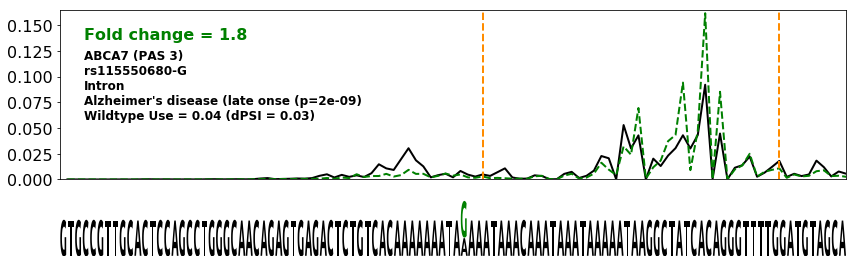

Gene = ACAA2
PAS = ACAA2.8
SNP ID = rs75276171-G
Native Isoform Use = 0.11
Delta PSI = 0.04


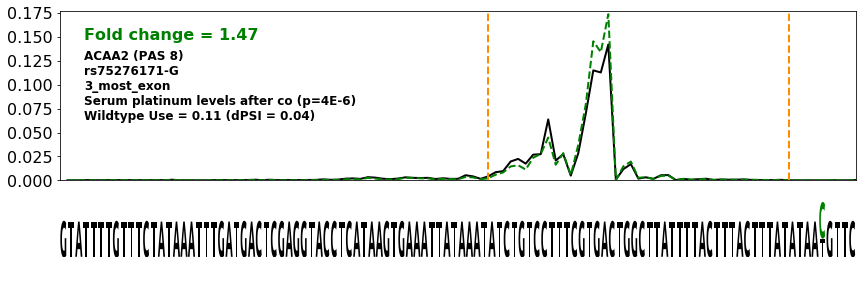

Gene = ANK1
PAS = ANK1.17
SNP ID = rs6150565-C
Native Isoform Use = 0.07
Delta PSI = -0.03


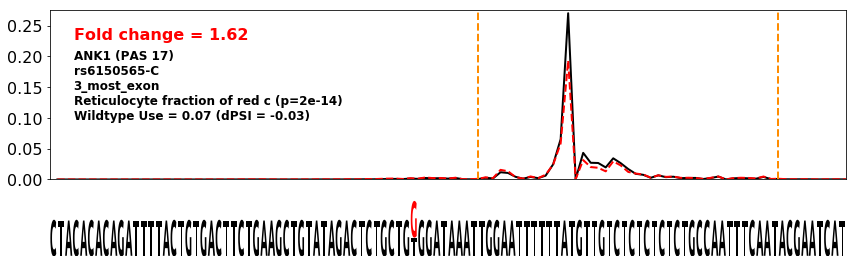

Gene = AP2B1
PAS = AP2B1.3
SNP ID = rs225285-C
Native Isoform Use = 0.02
Delta PSI = 0.01


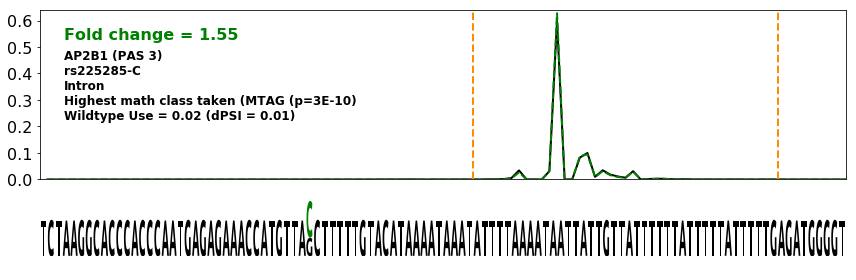

Gene = APOC1
PAS = APOC1.2
SNP ID = rs12721054-G
Native Isoform Use = 0.98
Delta PSI = -0.5


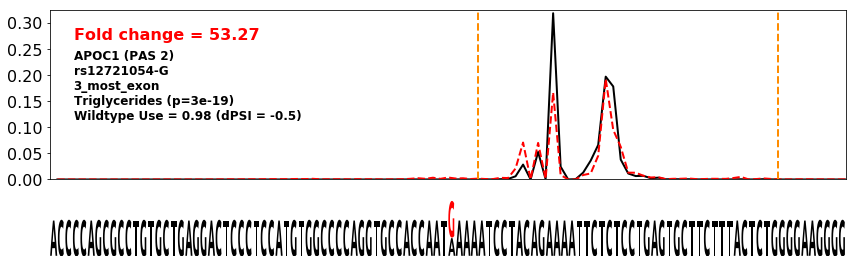

Gene = ARHGAP40
PAS = ARHGAP40.3
SNP ID = rs220519-T
Native Isoform Use = 0.55
Delta PSI = 0.09


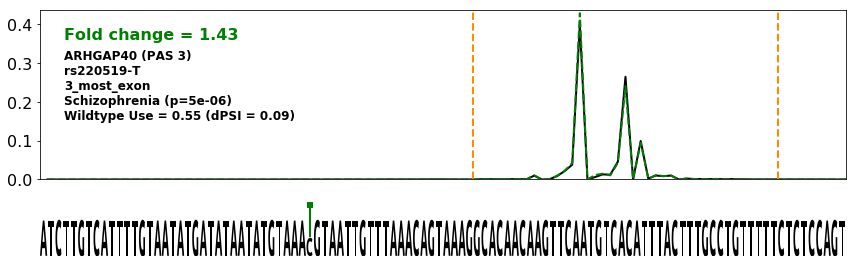

Gene = ARID5B
PAS = ARID5B.7
SNP ID = rs10821944-T
Native Isoform Use = 0.06
Delta PSI = 0.09


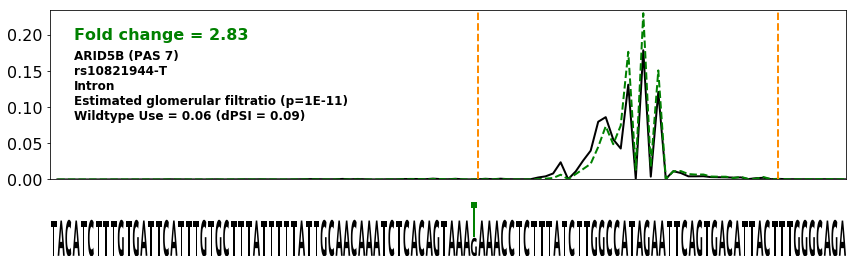

Gene = ASAH1
PAS = ASAH1.14
SNP ID = rs7508-A
Native Isoform Use = 0.76
Delta PSI = 0.04


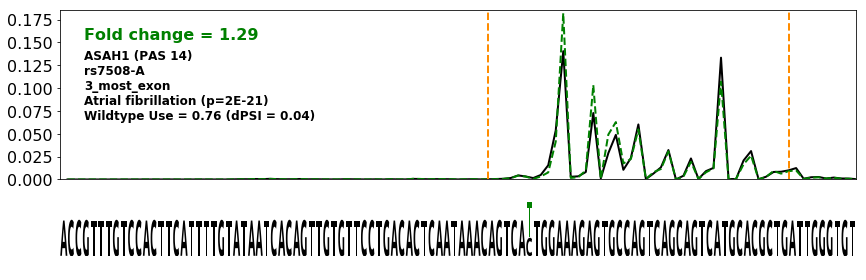

Gene = ATP1B1
PAS = ATP1B1.4
SNP ID = rs10919070-C
Native Isoform Use = 0.0
Delta PSI = 0.0


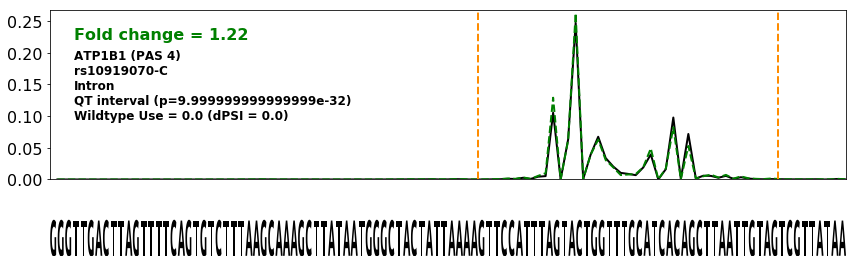

Gene = C1orf105
PAS = C1orf105.1
SNP ID = rs6691993-G
Native Isoform Use = 0.03
Delta PSI = -0.01


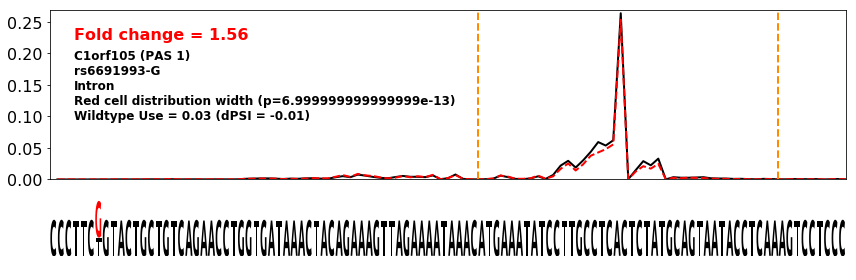

Gene = CACNA2D2
PAS = CACNA2D2.6
SNP ID = rs2236950-A
Native Isoform Use = 0.06
Delta PSI = 0.02


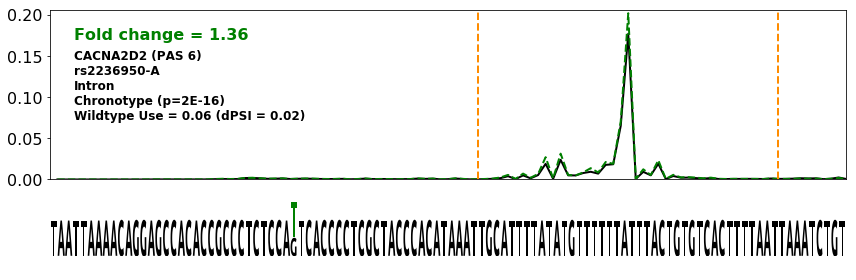

Gene = CCDC153
PAS = CCDC153.2
SNP ID = rs45535039-C
Native Isoform Use = 0.45
Delta PSI = 0.09


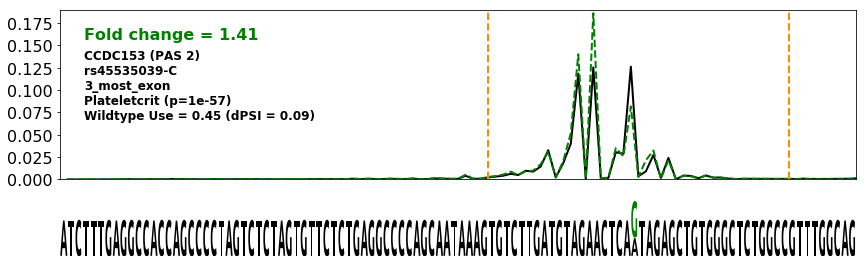

Gene = CD63
PAS = CD63.9
SNP ID = rs4759190-G
Native Isoform Use = 0.98
Delta PSI = -0.01


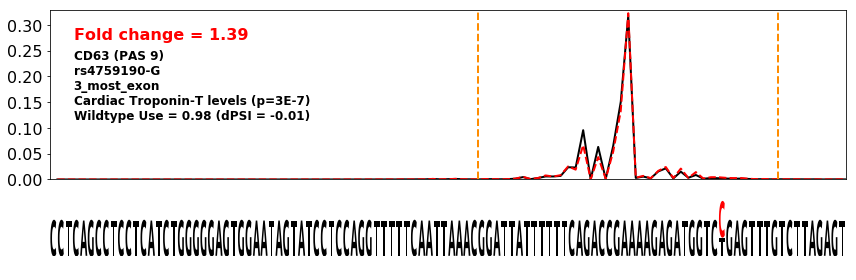

Gene = CREB3L2
PAS = CREB3L2.9
SNP ID = rs73729083-C
Native Isoform Use = 0.08
Delta PSI = 0.02


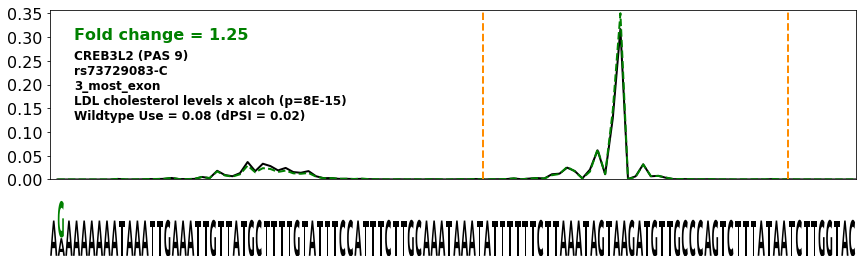

Gene = DDX17
PAS = DDX17.19
SNP ID = rs763121-G
Native Isoform Use = 0.01
Delta PSI = -0.01


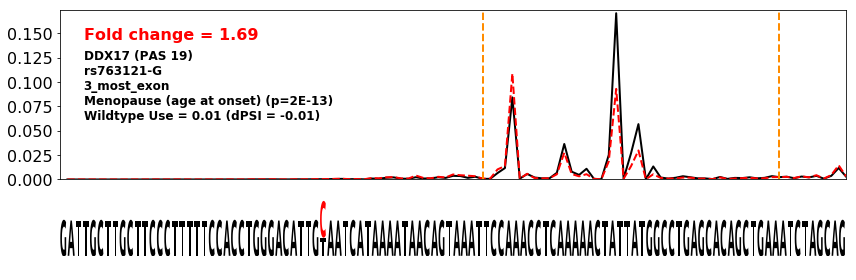

Gene = F2
PAS = F2.1
SNP ID = rs1799963-A
Native Isoform Use = 1.0
Delta PSI = 0.0


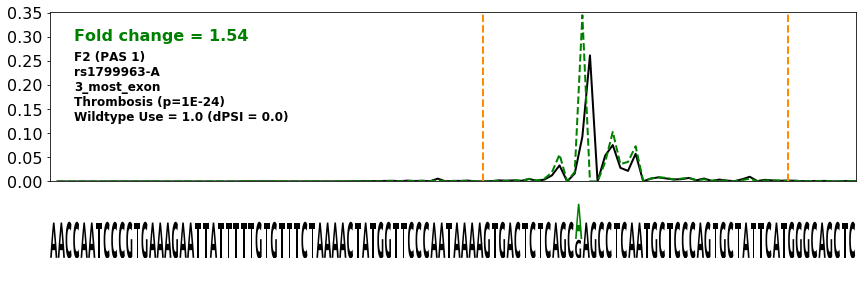

Gene = FADS2
PAS = FADS2.11
SNP ID = rs61897795-G
Native Isoform Use = 0.01
Delta PSI = 0.01


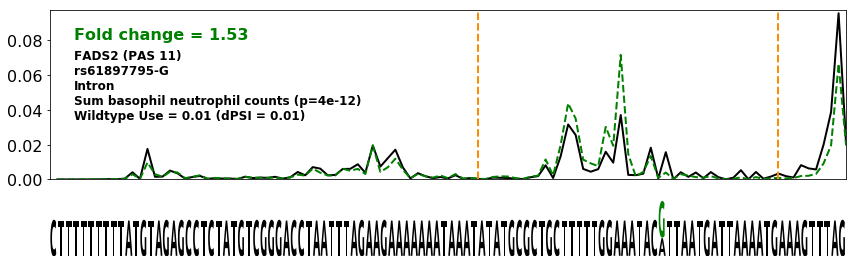

Gene = FNBP1
PAS = FNBP1.7
SNP ID = rs10760649-T
Native Isoform Use = 0.01
Delta PSI = -0.0


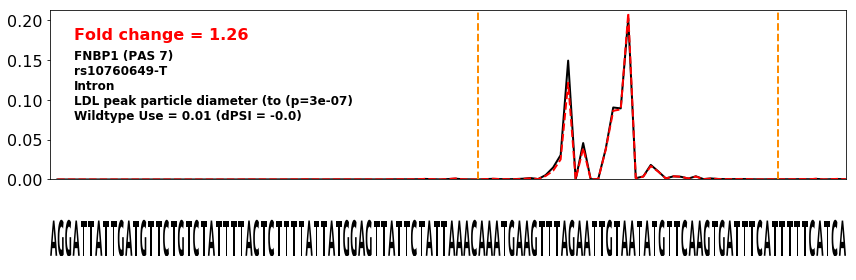

Gene = GSTO1
PAS = GSTO1.4
SNP ID = rs2282326-C
Native Isoform Use = 0.01
Delta PSI = 0.0


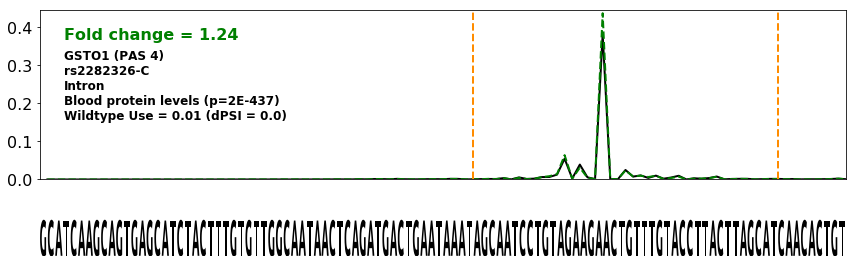

Gene = HCN1
PAS = HCN1.11
SNP ID = rs12522910-C
Native Isoform Use = 0.05
Delta PSI = -0.02


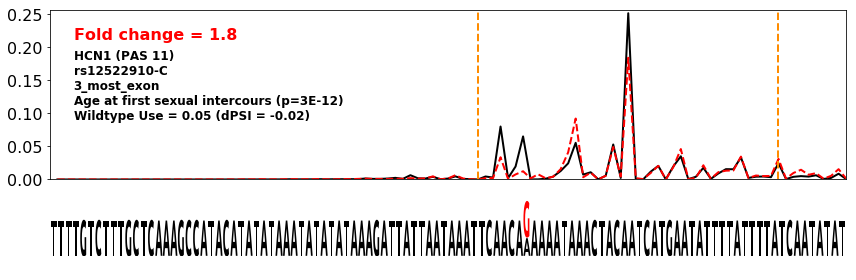

Gene = HDAC9
PAS = HDAC9.16
SNP ID = rs2074633-C
Native Isoform Use = 0.04
Delta PSI = 0.02


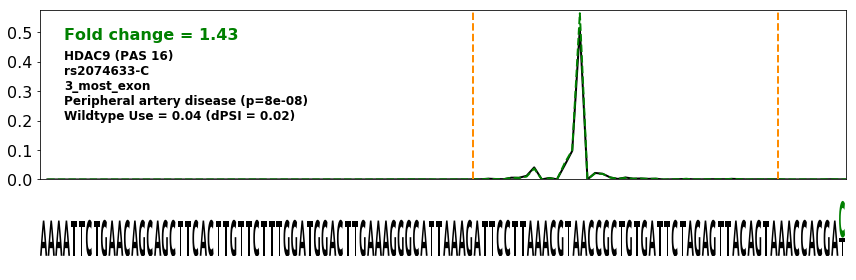

Gene = HIST1H2BC
PAS = HIST1H2BC.4
SNP ID = rs115740542-C
Native Isoform Use = 0.06
Delta PSI = 0.03


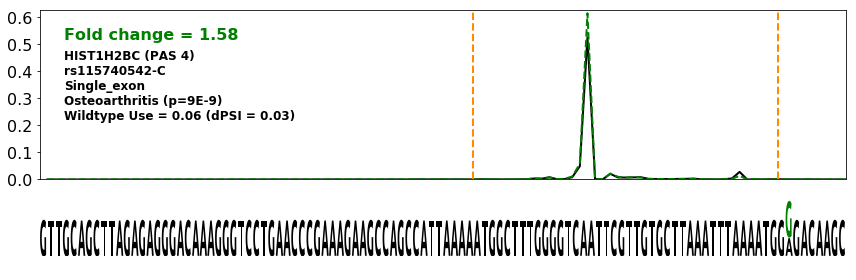

Gene = IREB2
PAS = IREB2.7
SNP ID = rs4299116-A
Native Isoform Use = 0.02
Delta PSI = -0.02


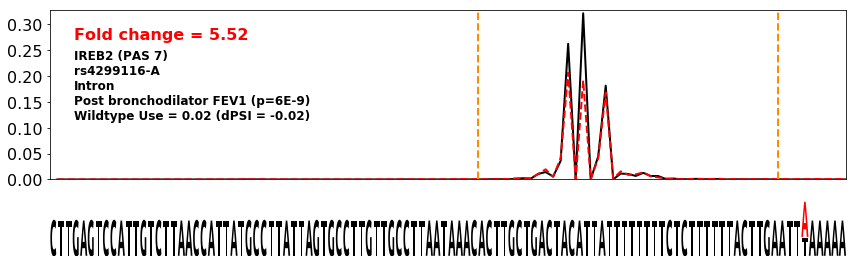

Gene = LBR
PAS = LBR.8
SNP ID = rs16844841-C
Native Isoform Use = 0.04
Delta PSI = -0.01


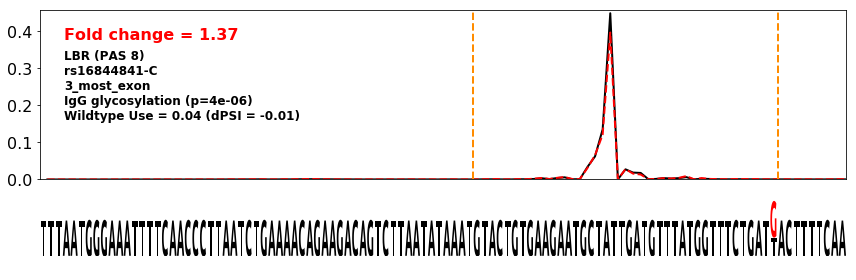

Gene = LEPR
PAS = LEPR.22
SNP ID = rs11208659-C
Native Isoform Use = 0.07
Delta PSI = -0.01


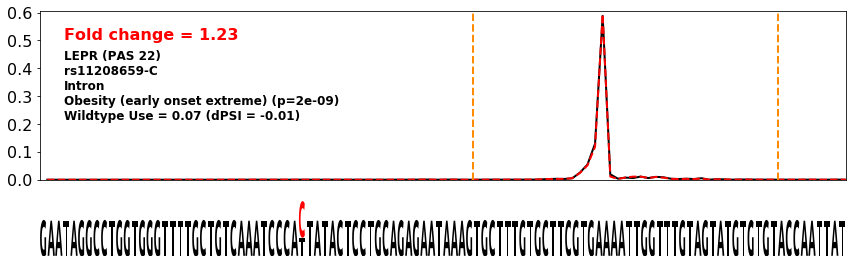

Gene = MAP3K11
PAS = MAP3K11.4
SNP ID = rs34686164-C
Native Isoform Use = 0.05
Delta PSI = 0.06


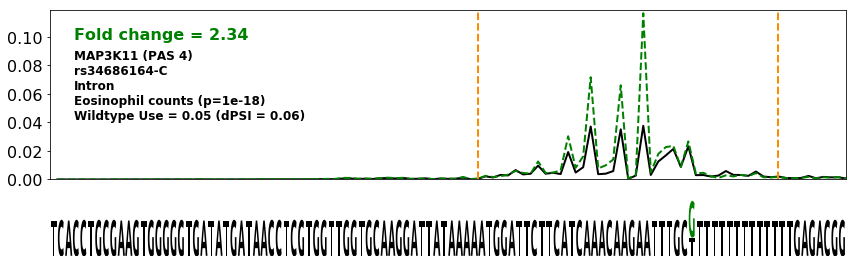

Gene = NEDD4
PAS = NEDD4.12
SNP ID = rs8032158-C
Native Isoform Use = 0.06
Delta PSI = 0.06


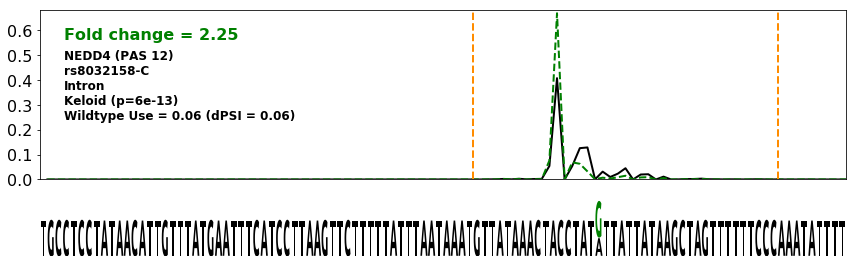

Gene = NELFA
PAS = NELFA.9
SNP ID = rs16342-TAACA
Native Isoform Use = 0.02
Delta PSI = -0.01


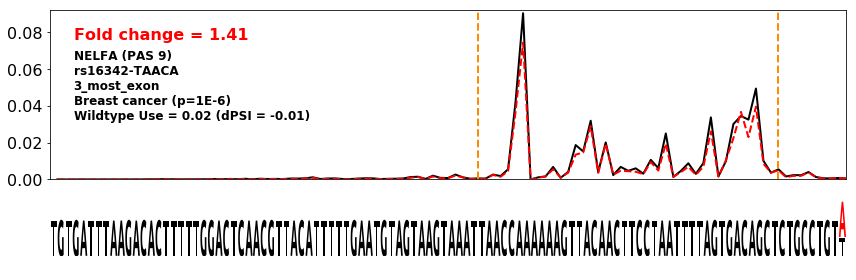

Gene = NELFA
PAS = NELFA.10
SNP ID = rs16342-TAACA
Native Isoform Use = 0.03
Delta PSI = -0.01


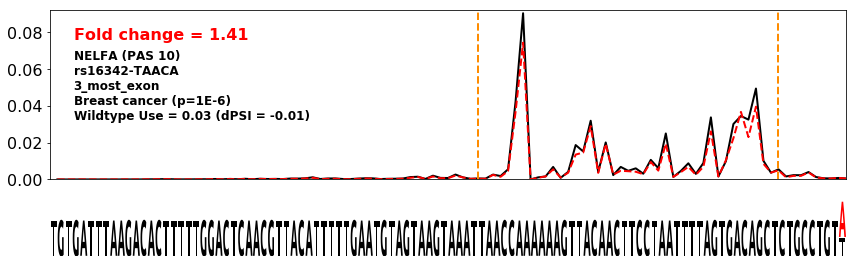

Gene = NOB1
PAS = NOB1.3
SNP ID = rs145944004-GA
Native Isoform Use = 0.02
Delta PSI = 0.01


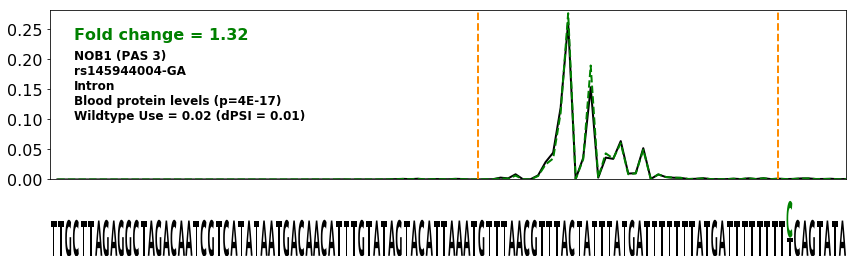

Gene = NPLOC4
PAS = NPLOC4.14
SNP ID = rs3208787-G
Native Isoform Use = 0.01
Delta PSI = 0.0


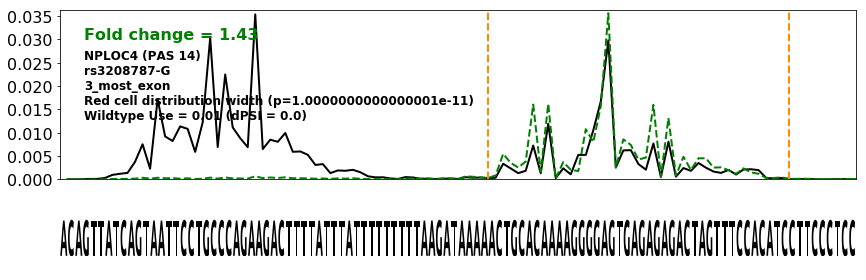

Gene = NSD1
PAS = NSD1.19
SNP ID = rs3088050-A
Native Isoform Use = 0.02
Delta PSI = -0.01


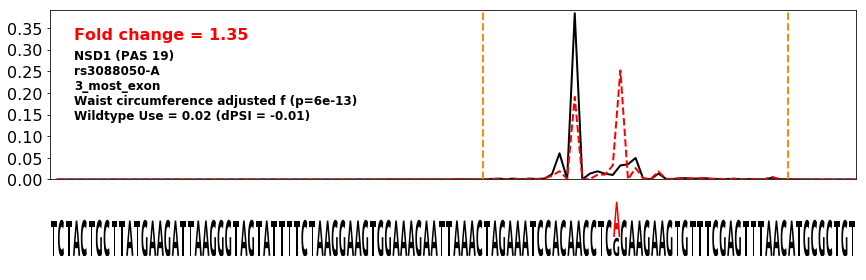

Gene = ORC3
PAS = ORC3.21
SNP ID = rs28381552-G
Native Isoform Use = 0.02
Delta PSI = -0.01


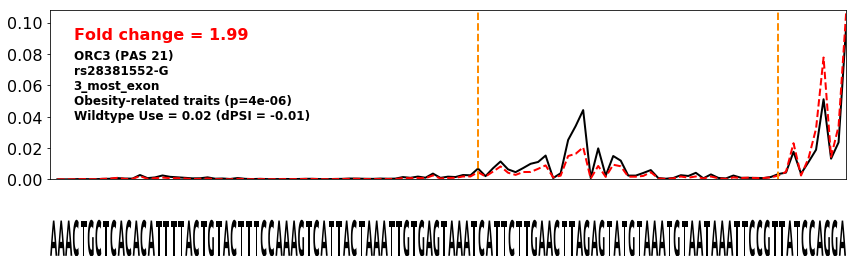

Gene = PCNX2
PAS = PCNX2.5
SNP ID = rs12135534-A
Native Isoform Use = 0.02
Delta PSI = 0.01


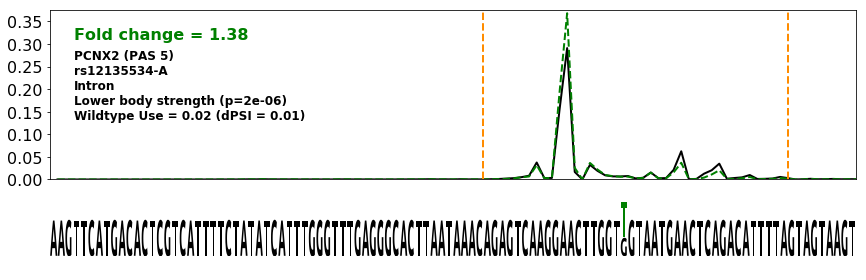

Gene = PDGFRB
PAS = PDGFRB.5
SNP ID = rs3816018-T
Native Isoform Use = 0.04
Delta PSI = 0.59


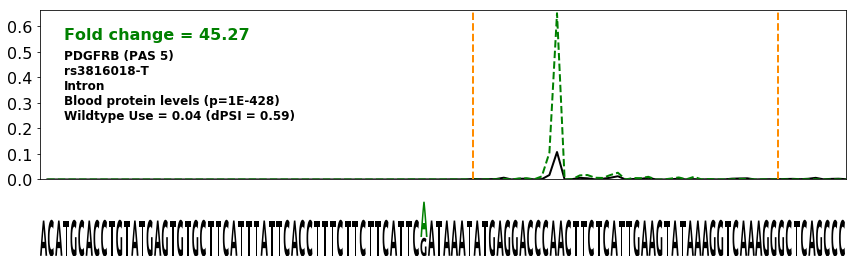

Gene = PIK3C2A
PAS = PIK3C2A.8
SNP ID = rs16933829-C
Native Isoform Use = 0.01
Delta PSI = 0.01


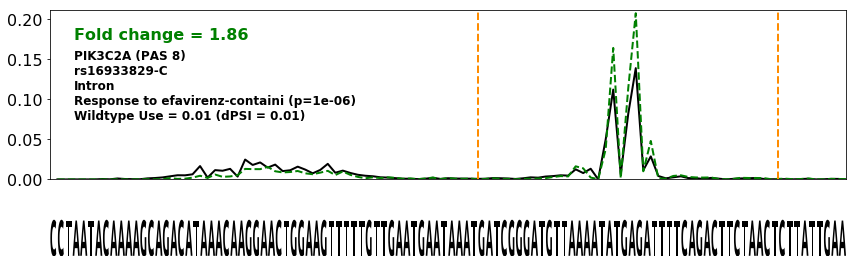

Gene = PLXNC1
PAS = PLXNC1.9
SNP ID = rs56290609-T
Native Isoform Use = 0.06
Delta PSI = -0.01


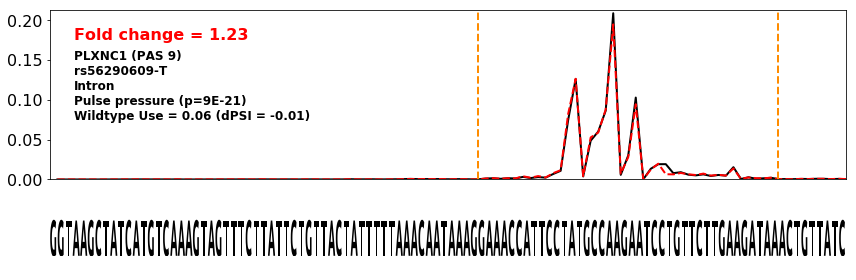

Gene = RIT1
PAS = RIT1.10
SNP ID = rs2282301-A
Native Isoform Use = 0.05
Delta PSI = 0.01


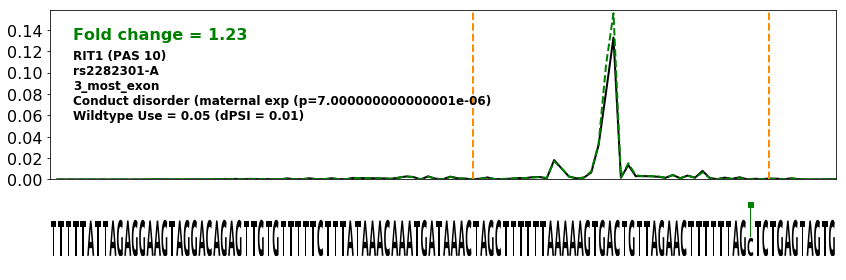

Gene = RTF1
PAS = RTF1.7
SNP ID = rs1942-G
Native Isoform Use = 0.02
Delta PSI = -0.02


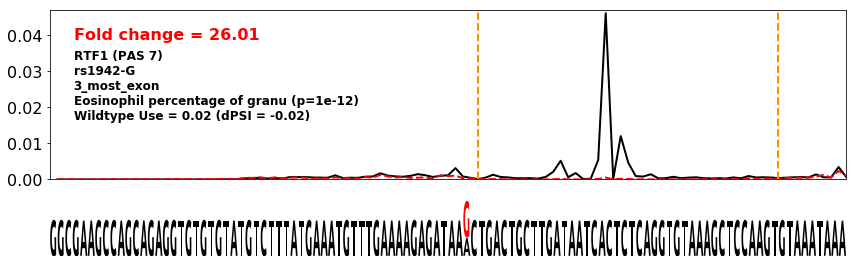

Gene = SEC14L5
PAS = SEC14L5.1
SNP ID = rs9925477-G
Native Isoform Use = 0.06
Delta PSI = -0.02


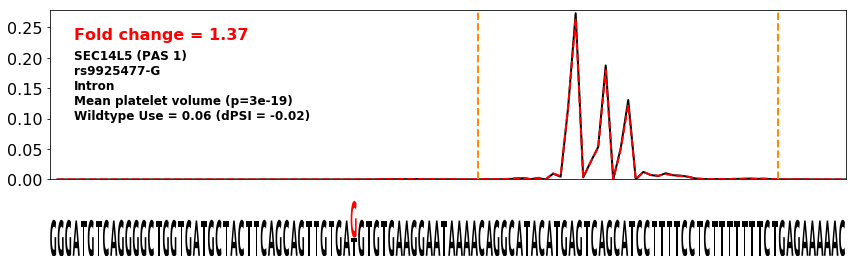

Gene = SEZ6L2
PAS = SEZ6L2.5
SNP ID = rs12917712-T
Native Isoform Use = 0.67
Delta PSI = 0.06


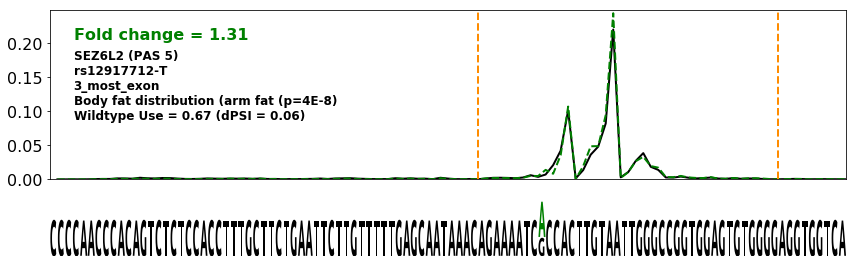

Gene = TCF12
PAS = TCF12.18
SNP ID = rs3803452-C
Native Isoform Use = 0.01
Delta PSI = 0.0


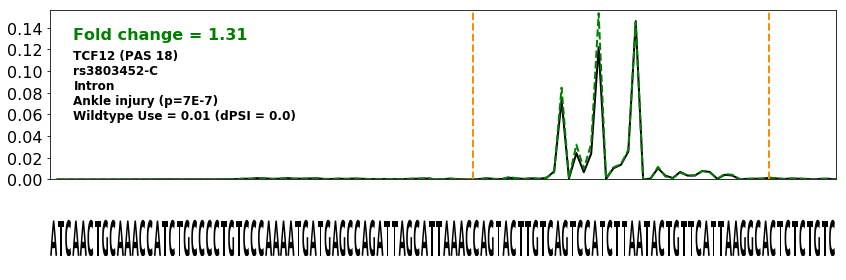

Gene = TNFRSF11A
PAS = TNFRSF11A.14
SNP ID = rs884205-C
Native Isoform Use = 0.1
Delta PSI = -0.07


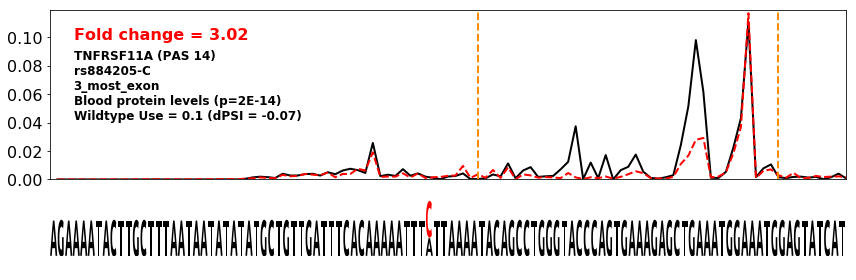

Gene = TP53
PAS = TP53.15
SNP ID = rs78378222-G
Native Isoform Use = 0.91
Delta PSI = -0.57


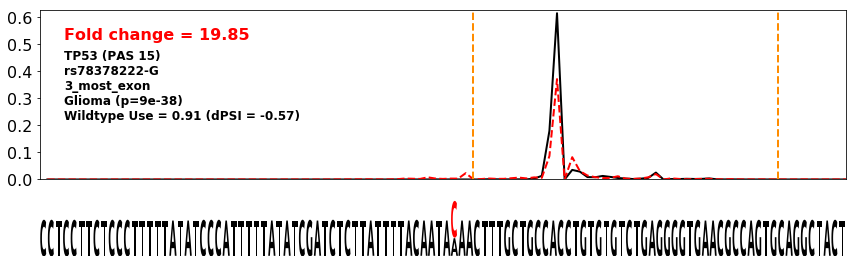

Gene = TP53
PAS = TP53.15
SNP ID = rs78378222-C
Native Isoform Use = 0.91
Delta PSI = -0.61


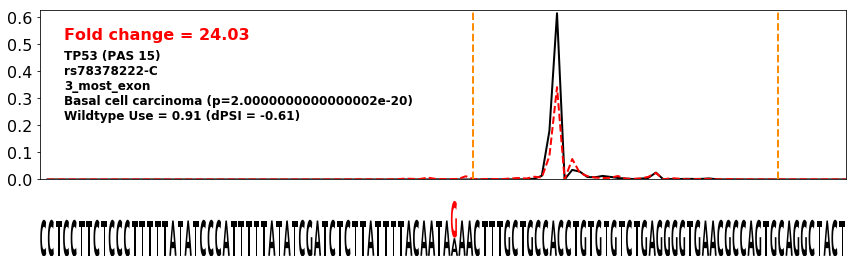

Gene = TRAF3
PAS = TRAF3.2
SNP ID = rs573617232-AT
Native Isoform Use = 0.02
Delta PSI = -0.01


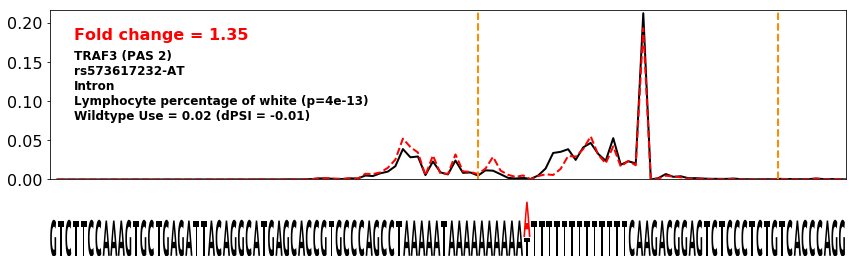

Gene = TUBD1
PAS = TUBD1.5
SNP ID = rs1292059-A
Native Isoform Use = 0.11
Delta PSI = 0.03


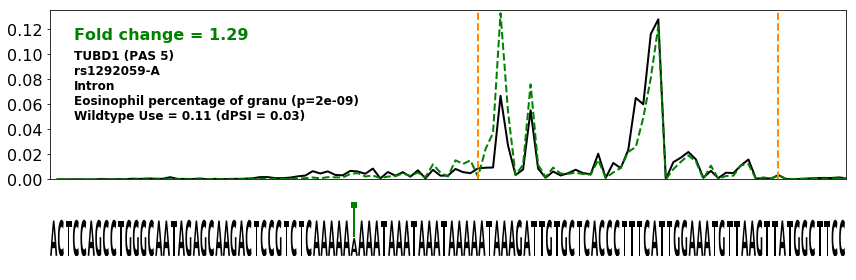

Gene = VPS26A
PAS = VPS26A.5
SNP ID = rs1802295-A
Native Isoform Use = 0.04
Delta PSI = 0.01


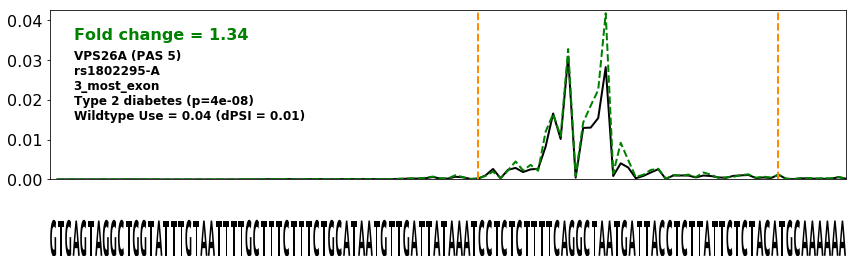

Gene = ZCCHC2
PAS = ZCCHC2.8
SNP ID = rs11557713-A
Native Isoform Use = 0.06
Delta PSI = -0.02


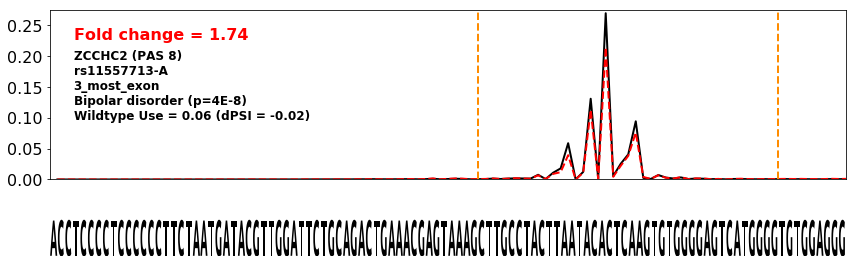

Gene = ZNF641
PAS = ZNF641.5
SNP ID = rs2732480-A
Native Isoform Use = 0.03
Delta PSI = 0.02


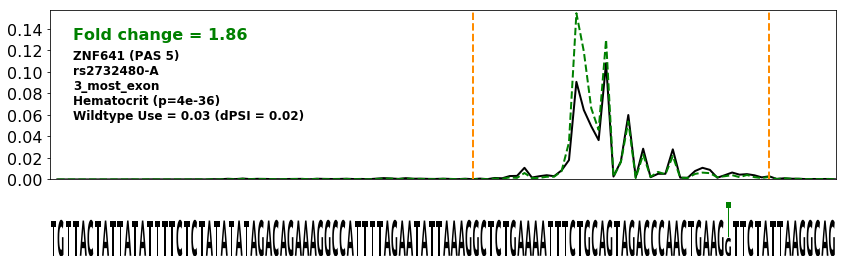

In [71]:
import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

#Filter GWAS dataset
keep_index = np.nonzero(((gwas_pred_df["pas"] != -1) & (gwas_pred_df["pas"] <= 2)) & (np.abs(gwas_pred_df["delta_isoform_logodds"]) >= 0.2))[0]

gwas_sel_df = gwas_pred_df.iloc[keep_index].copy().reset_index(drop=True)
gwas_sel_cuts_ref = gwas_pred_cuts_ref[keep_index, :]
gwas_sel_cuts_var = gwas_pred_cuts_var[keep_index, :]

print("n_gwas_variants = " + str(len(gwas_sel_df)))
print("-------------------------")

seq_start = 70 - 50
seq_end = 76 + 50

isoform_start = 77
isoform_end = 77 + 40

var_ix = 0
for _, row in gwas_sel_df.iterrows() :
    
    ref_seq = row['ref_seq']
    snv_pos = row['snp_pos']
    snv_nt = row['snp_nt']

    ref_cut = gwas_sel_cuts_ref[var_ix, :]
    var_cut = gwas_sel_cuts_var[var_ix, :]

    gene_name = row['gene']
    gene_id = row['gene_id']
    snp_id = row['snp_id']
    site_type = row['site_type']
    trait = row['trait']
    p_val = row['p_value']
    
    native_usage = round(row['native_usage'], 2)
    delta_usage = round(row['delta_usage'], 2)

    print('Gene = ' + gene_name)
    print('PAS = ' + gene_id)
    print('SNP ID = ' + snp_id)
    
    print('Native Isoform Use = ' + str(native_usage))
    print('Delta PSI = ' + str(delta_usage))
    
    plot_variant_with_cuts(ref_seq, snv_pos, snv_nt, ref_cut, var_cut, native_usage, delta_usage, gene_name, gene_id, snp_id, site_type, trait, p_val, figsize=(12, 4), height_ratios=[6, 2], isoform_start=isoform_start, isoform_end=isoform_end, seq_trim_start=seq_start, seq_trim_end=seq_end)
    
    var_ix += 1